# Attention Architecture

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import music21

In [3]:
# from fastai.text import *
from enum import Enum
import torch

In [4]:
import numpy as np
import torch.nn as nn

In [5]:
np.set_printoptions(edgeitems=10, threshold=40, linewidth=200)

In [6]:
import sys
sys.path.insert(0, '../../')
from src.fastai_data import *
from src.encode_data import *
from src.serve import *

Failed to load FluidSynth. Must install if you want to convert to wav files.


In [7]:
from src.music_transformer import *

In [8]:
from src.msklm import *

In [9]:
config = mlm_config(vocab)

In [10]:
config['n_layers'] = 2
# config['bptt'] = 512
config['bs'] = 8
config['mem_len'] = 32

In [11]:
config

{'ctx_len': 150,
 'n_heads': 8,
 'd_model': 512,
 'd_head': 64,
 'd_inner': 2048,
 'resid_p': 0.1,
 'attn_p': 0.1,
 'ff_p': 0.1,
 'embed_p': 0.1,
 'output_p': 0.1,
 'bias': True,
 'scale': True,
 'act': <Activation.GeLU: 3>,
 'double_drop': True,
 'tie_weights': True,
 'out_bias': True,
 'init': <function fastai.text.models.transformer.init_transformer(m)>,
 'mem_len': 32,
 'mask': True,
 'pad_idx': 1,
 'bos_idx': 0,
 'sep_idx': 8,
 'transpose_range': (0, 12),
 'rand_bptt': False,
 'note_range': (9, 137),
 'bs': 8,
 'bptt': 256,
 'vocab_size': 312,
 'enc_layers': 8,
 'dec_layers': 8,
 'n_layers': 2}

In [12]:
base_path = Path('../../data/midi/v18/sf4/')

In [13]:
cache_name = 'tmp/hook_c'
# cache_name = 'tmp/sample'

## Current DataLoading

In [58]:
test_config = config.copy()
test_config['transpose_range'] = None

In [67]:
msk_dl_tfms = [partial(mask_or_lm_tfm, p_mask=0.3, p_lm=1.0)]
msk_data = MusicDataBunch.load(base_path/'piano_duet', cache_name=cache_name, vocab=vocab, 
                              y_offset=1, dl_tfms=msk_dl_tfms, **test_config)

In [68]:
msk_data.train_dl.dl.dataset.transpose_values

In [63]:
lm_dl_tfms = [partial(mask_or_lm_tfm, p_lm=0.0)]
lm_data = MusicDataBunch.load(base_path/'piano_duet', cache_name=cache_name, vocab=vocab, 
                              y_offset=1, dl_tfms=lm_dl_tfms, **config)

## BERT Dataloading

In [14]:
# dl_tfms = [partial(random_msklm_tfm, p_lm=1.0)]
# # dl_tfms = [random_msklm_tfm]
# msklm_data = MusicDataBunch.load(base_path/'piano_duet', cache_name=cache_name, vocab=vocab, 
#                               train_tfms=[to_single_stream], valid_tfms=[to_single_stream],
#                               y_offset=1, dl_tfms=dl_tfms, **config)


In [15]:
# xb,yb = msklm_data.one_batch();

## Either or Data

In [16]:
dl_tfms = [partial(mask_or_lm_tfm, p_lm=0.5)]
# dl_tfms = [random_msklm_tfm]
msklm_data = MusicDataBunch.load(base_path/'piano_duet', cache_name=cache_name, vocab=vocab, 
                              y_offset=1, dl_tfms=dl_tfms, **config)


In [17]:
xb,yb = msklm_data.one_batch();

In [18]:
xb

[tensor([[149,   0,   1,  ...,  56, 145,   4],
         [149,   0,   1,  ...,  56, 145,  52],
         [149,   0,   1,  ...,  56, 145,  52],
         ...,
         [149,   0,   1,  ..., 114, 145,  52],
         [149,   0,   1,  ...,  56,   4,   4],
         [149,   0,   1,  ...,   4, 145,  52]]),
 None,
 tensor([[-132,    0,    0,  ...,  -16,  -16,  -16],
         [-132,    0,    0,  ...,  -16,  -16,  -16],
         [-132,    0,    0,  ...,  -16,  -16,  -16],
         ...,
         [-132,    0,    0,  ...,  -16,  -16,  -16],
         [-132,    0,    0,  ...,  -16,  -16,  -16],
         [-132,    0,    0,  ...,  -16,  -16,  -16]]),
 None]

## S2S Dataloading

In [35]:
np.pad(np.ones((4,1)), [(1,0),(0,0)], 'constant')

array([[0.],
       [1.],
       [1.],
       [1.],
       [1.]])

In [56]:
m2c_dl_tfms = [s2s_tfm]
m2c_data = MusicDataBunch.load(base_path/'s2s_encode', cache_name=cache_name, 
                               preloader_cls=S2SPreloader, dl_tfms=m2c_dl_tfms,
                               shuffle_dl=False, **config)

c2m_dl_tfms = [partial(s2s_tfm, mlm_type=MLMType.C2M)]
c2m_data = MusicDataBunch.load(base_path/'s2s_encode', cache_name=cache_name, 
                               preloader_cls=S2SPreloader, dl_tfms=c2m_dl_tfms,
                               shuffle_dl=False, **config)

In [57]:
m2c_data.train_dl.dl.dataset.on_epoch_begin()
m2c_data.train_dl.dl.dataset.on_epoch_end()
xb,yb = m2c_data.one_batch(); [x.shape for x in xb], yb[0].shape

([torch.Size([8, 256]),
  torch.Size([8, 256]),
  torch.Size([8, 256]),
  torch.Size([8, 256])],
 torch.Size([8, 256]))

In [23]:
vocab.stoi[MSEQ], vocab.stoi[CSEQ]

(6, 5)

In [24]:
c2m_data.train_dl.dl.dataset.on_epoch_begin()
c2m_data.train_dl.dl.dataset.on_epoch_end()
xb,yb = c2m_data.one_batch(); [x.shape for x in xb], yb[0].shape

([torch.Size([8, 256]),
  torch.Size([8, 256]),
  torch.Size([8, 256]),
  torch.Size([8, 256])],
 torch.Size([8, 256]))

## Datasets

In [26]:
datasets = [msklm_data, m2c_data, c2m_data]
combined_data = CombinedData(datasets)

# datasets = [nw_data]

## MSKLM

## Load

In [27]:
# loss_func = CrossEntropyFlat(ignore_index=vocab.pad_idx)
loss_func = MLMLoss()
learn = mlm_model_learner(combined_data, config.copy(), 
# learn = mlm_model_learner(datasets[0], config.copy(), 
                           loss_func=loss_func)

In [28]:
learn.metrics = [acc_ignore_pad, mask_acc, lm_acc, c2m_acc, m2c_acc]

In [29]:
from fastai.callbacks.rnn import RNNTrainer
learn.callbacks = [c for c in learn.callbacks if not isinstance(c, RNNTrainer)]
learn.callbacks.append(MLMTrainer(learn))

In [30]:
[type(c) for c in learn.callbacks]

[src.msklm.MLMTrainer]

In [31]:
learn = learn.to_fp16()

### Training

In [32]:
# learn.lr_find(num_it=500)
# learn.recorder.plot()

In [33]:
learn.validate()

[5.877538, tensor(0.0174), tensor(0.0990), tensor(0.), tensor(0.), tensor(0.)]

In [34]:
# try_pos again - max_norm 0.5
learn.fit_one_cycle(2, 1e-3)

epoch,train_loss,valid_loss,acc_ignore_pad,mask_acc,lm_acc,c2m_acc,m2c_acc,time
0,1.347190,1.435162,0.630273,0.570464,0.604596,0.620509,0.699876,04:36
1,1.096411,0.938729,0.713003,0.642254,0.654186,0.701591,0.814382,04:38


In [58]:
# no pos enc
learn.fit_one_cycle(2, 1e-3)

epoch,train_loss,valid_loss,acc_ignore_pad,mask_acc,lm_acc,c2m_acc,m2c_acc,time
0,1.368504,1.630741,0.557695,0.621955,0.593909,0.463462,0.584569,04:46
1,1.166014,0.985762,0.703072,0.645326,0.640728,0.683181,0.808016,04:47


In [58]:
# r_mask turned on
learn.fit_one_cycle(2, 1e-3)

epoch,train_loss,valid_loss,acc_ignore_pad,mask_acc,lm_acc,c2m_acc,m2c_acc,time
0,2.882826,3.098380,0.249519,0.215087,0.295160,0.278107,0.224342,04:59
1,2.751115,2.332490,0.363403,0.214629,0.327856,0.479483,0.378201,05:00


In [48]:
learn.validate()

[2.4201276, tensor(0.4476), 0, 0]

In [60]:
learn.save('save_s2s_1')

In [59]:
learn.fit_one_cycle(2, 1e-3)

epoch,train_loss,valid_loss,acc_ignore_pad,mask_acc,lm_acc,c2m_acc,m2c_acc,time


KeyboardInterrupt: 

## Load sample train

In [128]:
load_path = base_path/'piano_duet/models/save_s2s_1.pth'
state = torch.load(load_path, map_location='cpu')
get_model(learn.model).load_state_dict(state['model'])
load_path

PosixPath('../../data/midi/v17/sf4/piano_duet/models/save_s2s_1.pth')

In [ ]:
# learn.load('sample_train')

## Load existing

In [ ]:
saved_models = get_files(base_path/'models/unilm', recurse=True, extensions=['.pth']); saved_models

In [ ]:
# load_path = saved_models[1]
# state = torch.load(load_path, map_location='cpu')
# get_model(learn.model).load_state_dict(state['model'])
# load_path

## Prediction

Prediction algo

In [164]:
csv_path = base_path/f'piano_duet/piano_duet.csv'
csv = pd.read_csv(csv_path)
df = csv.loc[csv['numpy'].notna()];

# keywords = 'la bamba'.replace(' ', '|')
title_filter = df['title'].str.contains('la-bamba')==True
artist_filter = df['artist'].str.contains('')==True
results = df[title_filter & artist_filter]; results.head()
results = results[results.source == 'hooktheory_c']; results.head()

,song_url,section,numpy,ht_mode,midi,title,ht_time_signature,mxl,ht_offset,ht_bpm,ht_key,md5,midi_title,artist,genres,parts,source
193179,https://www.hooktheory.com/theorytab/view/ritc...,chorus,piano_duet/hooktheory/pianoroll/r/ritchie-vale...,1.0,midi_sources/hooktheory/pianoroll/r/ritchie-va...,la-bamba,4.0,NaN,0.0,144.0,C,aeee134e4034e5f98bb630c56d2f7f8c,La Bamba,ritchie-valen,"Pop,Rock",chorus,hooktheory_c


In [165]:
idx = 0
file = base_path/results.numpy.values[idx];
orig = base_path/results.midi.values[idx];
file, orig

(PosixPath('../../data/midi/v15/piano_duet/hooktheory/pianoroll/r/ritchie-valen/la-bamba/chorus_key_cmajor.npy'),
 PosixPath('../../data/midi/v15/midi_sources/hooktheory/pianoroll/r/ritchie-valen/la-bamba/chorus_key_cmajor.mid'))

In [166]:
seed_len = 40
song_np = np.load(file)
seed_np = np.load(file)[:seed_len]
xb = torch.tensor(to_single_stream(seed_np, vocab=vocab))[None]
if torch.cuda.is_available(): xb = xb.cuda()

In [167]:
# seed_stream = npenc2stream(seed_np)
# seed_stream.show()

In [168]:
xb

tensor([[  0,   1,   8, 150,  64, 141,   8, 141,  66, 141,   8, 141,  68, 141,
           8, 141,  69, 143,  64, 147,  61, 147,  57, 147,   8, 143,  73, 141,
           8, 141,  76, 141,   8, 141,  74, 141,  69, 147,  66, 147,  62, 147,
           8, 141,  74, 141,   8, 141,  78, 141,   8, 141,  76, 143,   8, 141,
          59, 147,  56, 147,  52, 147,   8, 141,  64, 141,   8, 141,  68, 141,
           8, 141,  71, 141,   8, 141,  74, 141,  69, 147,  66, 147]],
       device='cuda:0')

In [36]:
# task_type = torch.full_like(xb, TaskType.NextWord.value)

# learn.model.reset()

# res = learn.pred_batch(batch=((xb,task_type,xb),xb)); res

# preds = loss_batch(learn.model.eval(), (xb,task_type,xb), yb); preds

In [37]:
# last = res[-1][0, -1]; last[143]
# idx = torch.multinomial(res[-1][0, -1], 1).item(); idx

In [39]:
# vocab.itos[143]

In [170]:
# if xb.shape[0] > 1: xb = xb[0][None]
# seed = xb.cpu().numpy().squeeze()
# yb = torch.ones_like(xb)
# res = learn.pred_batch(batch=((xb, torch.full_like(xb, TaskType.NextWord.value),xb),(yb)))
# res[-1][0, -1][141]

In [41]:
out_s, seed_s = predict_nw(learn, xb, n_words=40)

In [176]:
out_s, seed_s = predict_nw_nomem(learn, xb, n_words=40)

Updating mem length to: 0


tensor([[  0,   1,   8, 150,  64, 141,   8, 141,  66, 141,   8, 141,  68, 141,
           8, 141,  69, 143,  64, 147,  61, 147,  57, 147,   8, 143,  73, 141,
           8, 141,  76, 141,   8, 141,  74, 141,  69, 147,  66, 147,  62, 147,
           8, 141,  74, 141,   8, 141,  78, 141,   8, 141,  76, 143,   8, 141,
          59, 147,  56, 147,  52, 147,   8, 141,  64, 141,   8, 141,  68, 141,
           8, 141,  71, 141,   8, 141,  74, 141,  69, 147,  66, 147]],
       device='cuda:0')
Updating mem length to: 512
tensor([[  0,   1,   8, 150,  64, 141,   8, 141,  66, 141,   8, 141,  68, 141,
           8, 141,  69, 143,  64, 147,  61, 147,  57, 147,   8, 143,  73, 141,
           8, 141,  76, 141,   8, 141,  74, 141,  69, 147,  66, 147,  62, 147,
           8, 141,  74, 141,   8, 141,  78, 141,   8, 141,  76, 143,   8, 141,
          59, 147,  56, 147,  52, 147,   8, 141,  64, 141,   8, 141,  68, 141,
           8, 141,  71, 141,   8, 141,  74, 141,  69, 147,  66, 147,  62]],
       devi

tensor([[  0,   1,   8, 150,  64, 141,   8, 141,  66, 141,   8, 141,  68, 141,
           8, 141,  69, 143,  64, 147,  61, 147,  57, 147,   8, 143,  73, 141,
           8, 141,  76, 141,   8, 141,  74, 141,  69, 147,  66, 147,  62, 147,
           8, 141,  74, 141,   8, 141,  78, 141,   8, 141,  76, 143,   8, 141,
          59, 147,  56, 147,  52, 147,   8, 141,  64, 141,   8, 141,  68, 141,
           8, 141,  71, 141,   8, 141,  74, 141,  69, 147,  66, 147,  62, 147,
           8, 141,  73, 141,   8, 141,  74, 141,   8, 141,  73, 143,   8, 143]],
       device='cuda:0')
tensor([[  0,   1,   8, 150,  64, 141,   8, 141,  66, 141,   8, 141,  68, 141,
           8, 141,  69, 143,  64, 147,  61, 147,  57, 147,   8, 143,  73, 141,
           8, 141,  76, 141,   8, 141,  74, 141,  69, 147,  66, 147,  62, 147,
           8, 141,  74, 141,   8, 141,  78, 141,   8, 141,  76, 143,   8, 141,
          59, 147,  56, 147,  52, 147,   8, 141,  64, 141,   8, 141,  68, 141,
           8, 141,  71, 14

tensor([[  0,   1,   8, 150,  64, 141,   8, 141,  66, 141,   8, 141,  68, 141,
           8, 141,  69, 143,  64, 147,  61, 147,  57, 147,   8, 143,  73, 141,
           8, 141,  76, 141,   8, 141,  74, 141,  69, 147,  66, 147,  62, 147,
           8, 141,  74, 141,   8, 141,  78, 141,   8, 141,  76, 143,   8, 141,
          59, 147,  56, 147,  52, 147,   8, 141,  64, 141,   8, 141,  68, 141,
           8, 141,  71, 141,   8, 141,  74, 141,  69, 147,  66, 147,  62, 147,
           8, 141,  73, 141,   8, 141,  74, 141,   8, 141,  73, 143,   8, 143,
          71, 141,   8, 141,  69, 141,   8, 141,  71, 141,  59, 147,  56, 147]],
       device='cuda:0')
tensor([[  0,   1,   8, 150,  64, 141,   8, 141,  66, 141,   8, 141,  68, 141,
           8, 141,  69, 143,  64, 147,  61, 147,  57, 147,   8, 143,  73, 141,
           8, 141,  76, 141,   8, 141,  74, 141,  69, 147,  66, 147,  62, 147,
           8, 141,  74, 141,   8, 141,  78, 141,   8, 141,  76, 143,   8, 141,
          59, 147,  56, 14

In [177]:
[vocab.itos[i] for i in out_s]

['n53',
 'd8',
 'xxsep',
 'd2',
 'n64',
 'd2',
 'xxsep',
 'd2',
 'n65',
 'd2',
 'xxsep',
 'd2',
 'n64',
 'd4',
 'xxsep',
 'd4',
 'n62',
 'd2',
 'xxsep',
 'd2',
 'n60',
 'd2',
 'xxsep',
 'd2',
 'n62',
 'd2',
 'n50',
 'd8',
 'n47',
 'd8',
 'n43',
 'd8',
 'xxsep',
 'd2',
 'n62',
 'd2',
 'xxsep',
 'd2',
 'n64',
 'd2']

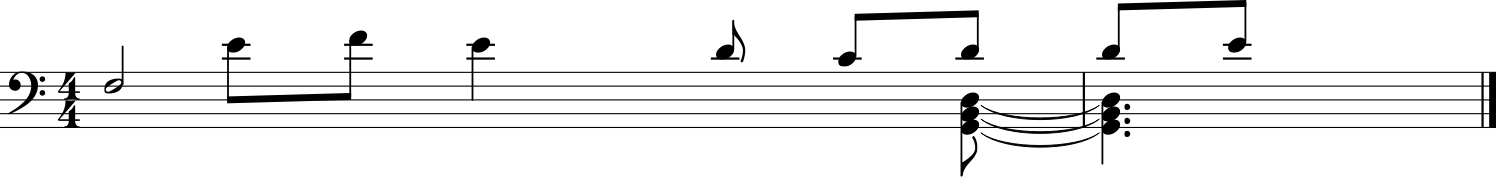

In [178]:
stream = npenc2stream(to_double_stream(out_s))
stream.show()

In [44]:
stream.show('midi')

## Predict Seq2Seq

In [182]:
csv_path = base_path/f's2s_encode/s2s_encode.csv'
csv = pd.read_csv(csv_path)
df = csv.loc[csv['numpy'].notna()];

# keywords = 'la bamba'.replace(' ', '|')
title_filter = df['title'].str.contains('la-bamba')==True
artist_filter = df['artist'].str.contains('')==True
results = df[title_filter & artist_filter]; results.head()
results = results[results.source == 'hooktheory_c']; results.head()

,ht_offset,ht_bpm,ht_mode,midi,ht_time_signature,parts,title,section,song_url,md5,ht_key,midi_title,genres,source,artist,mxl,numpy
192022,0.0,144.0,1.0,midi_sources/hooktheory/pianoroll/r/ritchie-va...,4.0,chorus,la-bamba,chorus,https://www.hooktheory.com/theorytab/view/ritc...,aeee134e4034e5f98bb630c56d2f7f8c,C,La Bamba,"Pop,Rock",hooktheory_c,ritchie-valen,NaN,s2s_encode/hooktheory/pianoroll/r/ritchie-vale...


In [183]:
idx = 0
file = base_path/results.numpy.values[idx];
orig = base_path/results.midi.values[idx];
file, orig

(PosixPath('../../data/midi/v15/s2s_encode/hooktheory/pianoroll/r/ritchie-valen/la-bamba/chorus_key_cmajor.npy'),
 PosixPath('../../data/midi/v15/midi_sources/hooktheory/pianoroll/r/ritchie-valen/la-bamba/chorus_key_cmajor.mid'))

In [184]:
melody_np, chord_np = np.load(file, allow_pickle=True)

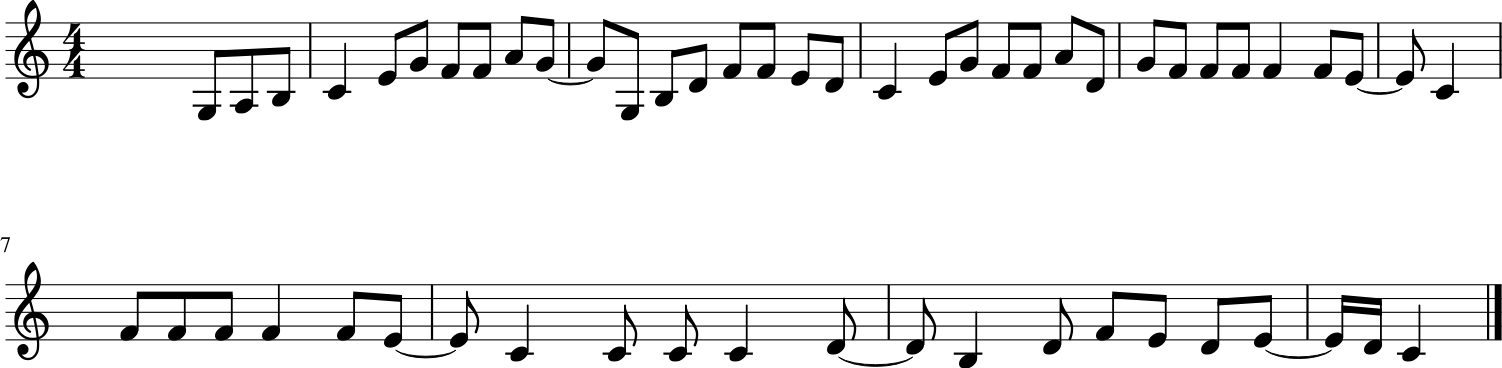

In [185]:
npenc2stream(melody_np).show()

In [186]:
def partenc2seq2seq(part_np, part_type=MSEQ, vocab=vocab, bptt=512, translate=False):
    part_meta = np.array([vocab.stoi[part_type], vocab.stoi[avg_tempo(part_np)]])
    s2s_out = to_single_stream(part_np, start_seq=part_meta)
    if translate:
        s2s_out = np.pad(s2s_out, (1,bptt), 'constant', constant_values=(vocab.stoi[CLS], vocab.pad_idx))[:bptt]
    else:
        s2s_out = np.pad(s2s_out, (0,bptt), 'constant', constant_values=vocab.pad_idx)[:bptt]
    return s2s_out

In [187]:
melody_np

array([[-1, 11],
       [55,  2],
       [-1,  2],
       [57,  2],
       ...,
       [-1,  3],
       [62,  1],
       [-1,  1],
       [60,  4]])

In [188]:
chord_np

array([[-1, 17],
       [55,  8],
       [52,  8],
       [48,  8],
       ...,
       [-1,  8],
       [55,  8],
       [52,  8],
       [48,  8]])

In [189]:
mpart[:20]

array([  6, 273,   8, 150,  64, 141,   8, 141,  66, 141,   8, 141,  68, 141,   8, 141,  69, 143,   8, 143])

In [190]:
mpart = partenc2seq2seq(melody_np)

In [191]:
cpart = partenc2seq2seq(chord_np, part_type=CSEQ, translate=True)

In [192]:
xb = mpart; xb

array([  6, 273,   8, 150, ...,   1,   1,   1,   1])

In [193]:
yb = cpart; yb

array([  3,   5, 273,   8, ...,   1,   1,   1,   1])

In [194]:
xb.shape, yb.shape

((512,), (512,))

In [195]:
xb = torch.tensor(xb)[None].cuda()
yb = torch.tensor(yb)[None].cuda()

In [196]:
learn.model.update_mem_len(TaskType.Seq2Seq.value)
task_type = torch.full_like(xb, TaskType.Seq2Seq.value)
res = learn.pred_batch(batch=((xb,task_type,yb),yb))

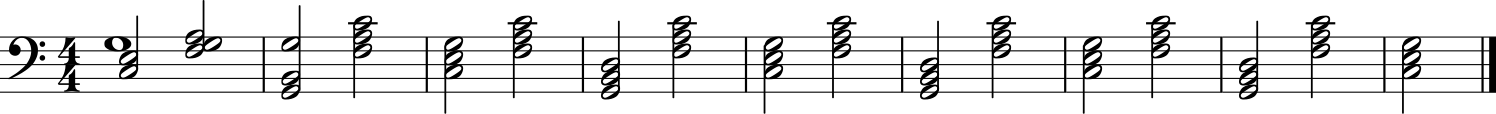

In [197]:
z = res[-1].argmax(-1)
z_str = to_double_stream(z.cpu().numpy()[:,:])
npenc2stream(z_str).show()

In [198]:
npenc2stream(z_str).show('midi')

In [202]:
yb_seed = yb[:,:3]
pad = xb.shape[-1]-yb_seed.shape[-1]

In [203]:
yb_out = predict_s2s(learn, xb, yb)

In [204]:
yb_out

tensor([[  3,   5, 273,   8, 156,  64, 147,  61, 147,  57, 147,   8, 147,  61,
         147,  57, 147,  54, 147,   8, 147,  64, 147,  61, 147,  57, 147,   8,
         147,  59, 147,  56, 147,  52, 147,   8, 147,  64, 147,  61, 147,  57,
         147,   8, 147,  61, 147,  57, 147,  54, 147,   8, 147,  64, 147,  61,
         147,  57, 147,   8, 147,  59, 147,  56, 147,  52, 147,   8, 147,  64,
         147,  61, 147,  57, 147,   8, 147,  61, 147,  57, 147,  54, 147,   8,
         147,  64, 147,  61, 147,  57, 147,   8, 147,  59, 147,  56, 147,  52,
         147,   8, 147,  64, 147,  61, 147,  57, 147,   8, 147,  61, 147,  57,
         147,  54, 147,   8, 147,  64, 147,  61, 147,  57, 147,   8, 147,  59,
         147,  56, 147,  52, 147,   8, 147,  64, 147,  61, 147,  57, 147]],
       device='cuda:0')

In [205]:
yb_test = to_double_stream(yb_out.cpu().numpy()[:,1:])

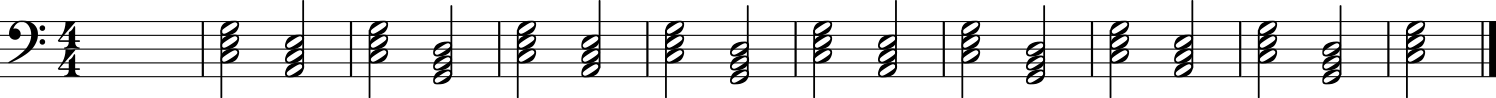

In [206]:
npenc2stream(yb_test).show()

In [207]:
npenc2stream(yb_test).show('midi')